# Homework 4 Till Meineke


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Dataset preparation

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

We already used it last week, so we can reuse the extracted [csv-file](../03-classification/data/bank-full.csv).

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not.

In [3]:
df = pd.read_csv("../03-classification/data/bank-full.csv", sep=";")
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
features = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y"
]

df = df[features].copy()

In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [7]:
num_features = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous",
]

scores = pd.DataFrame(columns=['feature', 'auc'])
for feat in num_features:
    auc = roc_auc_score(y_train, df_train[feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feat])
    print('%16s, %.3f' % (feat, auc))
    scores.loc[len(scores)] = [feat, auc]

             age, 0.512
         balance, 0.589
             day, 0.526
        duration, 0.815
        campaign, 0.571
           pdays, 0.590
        previous, 0.599


In [8]:
scores.sort_values(by='auc', ascending=False)

,feature,auc
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
4,campaign,0.571454
2,day,0.525958
0,age,0.512186


Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [9]:
print("The highest AUC has: ", scores.sort_values(by='auc', ascending=False).iloc[0].feature)

The highest AUC has:  duration


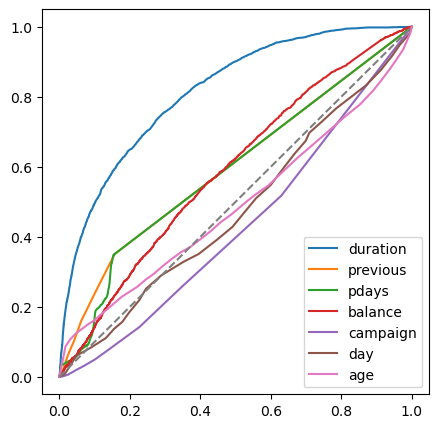

In [14]:
y_train_binary = [1 if y == "yes" else 0 for y in y_train]


plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train_binary, df_train.duration)
plt.plot(fpr, tpr, label="duration")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.previous)
plt.plot(fpr, tpr, label="previous")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.pdays)
plt.plot(fpr, tpr, label="pdays")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.balance)
plt.plot(fpr, tpr, label="balance")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.campaign)
plt.plot(fpr, tpr, label="campaign")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.day)
plt.plot(fpr, tpr, label="day")

fpr, tpr, _ = roc_curve(y_train_binary, df_train.age)
plt.plot(fpr, tpr, label="age")


plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

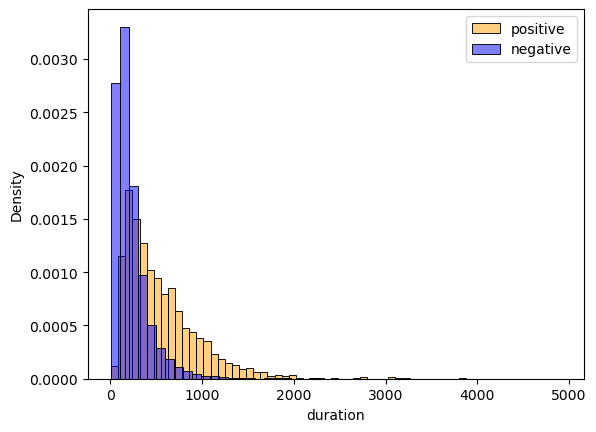

In [16]:
sns.histplot(
    df_train.duration[y_train == "yes"],
    stat="density",
    bins=50,
    color="orange",
    alpha=0.5,
    label="positive",
)
sns.histplot(
    df_train.duration[y_train == "no"],
    stat="density",
    bins=50,
    color="blue",
    alpha=0.5,
    label="negative",
)

plt.legend()
plt.show()

## Question 2: Training the model


Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [17]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]


What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [22]:
print("The AUC score is: ", round(roc_auc_score(y_val, y_pred), 3))

The AUC score is:  0.9


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [26]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == "yes")
        actual_negative = (y_val == "no")

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [27]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [28]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,927,1493,171,6451
20,0.2,712,692,386,7252
30,0.3,565,409,533,7535
40,0.4,462,272,636,7672
50,0.5,373,193,725,7751
60,0.6,291,137,807,7807
70,0.7,225,101,873,7843
80,0.8,148,67,950,7877
90,0.9,76,27,1022,7917


In [29]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

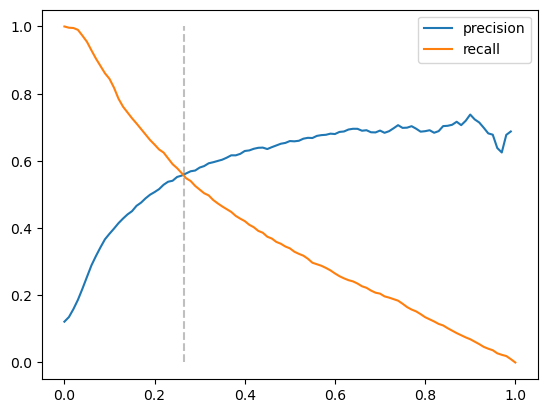

In [31]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.265, 0, 1, color="grey", linestyle="--", alpha=0.5)

plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.265

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [32]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [33]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.220000
tp            686.000000
fp            611.000000
fn            412.000000
tn           7333.000000
p               0.528913
r               0.624772
f1              0.572860
Name: 22, dtype: float64

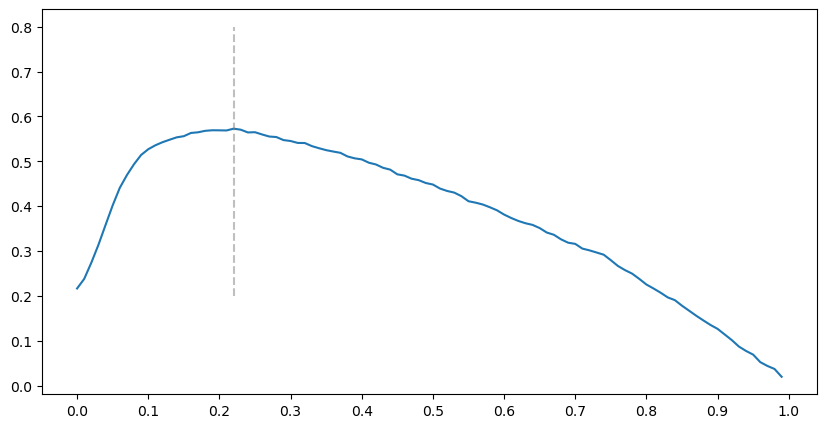

In [36]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.22, 0.2, 0.8, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

At which threshold F1 is maximal?

- 0.22

## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [40]:
columns = list(df.columns)
columns.remove('y')
columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [41]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [43]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


How large is standard devidation of the scores across different folds?

* 0.006

## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 0.01, 0.1, 0.5, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%5s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C= 0.01, 0.902 +- 0.005
C=  0.1, 0.906 +- 0.005
C=  0.5, 0.906 +- 0.006
C=    1, 0.906 +- 0.006
C=   10, 0.906 +- 0.006


Which C leads to the best mean score?

- 0.001

## Homework URL

[Homework 04](https://github.com/TillMeineke/ML_Zoomcamp2024_hw/blob/main/04-evaluation/homework_04_till_meineke.ipynb)

## Learning in public links (optional) 

## Time spent on lectures (hours) (optional)

## Time spent on homework (hours) (optional)

## FAQ contribution (FAQ document, optional)